파이썬 머신러닝 완벽가이드 ch7.p. 427~440

# 평균 이동

**평균 이동**은 K-평균과 유사하게 중심을 군집의 중심으로 지속적으로 움직이며 군집화를 수행한다. 그러나 평균이동은 중심을 데이터가 모여있는 밀도가 가장 높은 곳으로 이동시킨다.

평균이동 군집화는 데이터의 분포도를 이용하여 군집 중심점을 찾는다. 군집 중심점은 데이터 포인트가 모여있는 곳이라는 생각에서 착안하였으며, 이를 위해 pdf를 이용한다. pdf가 피크인 점을 군집 중심점으로 선정하며 pdf를 찾기 위해 KDE를 이용한다.

평균이동 군집화는 특정 데이터를 반경 내의 pdf가 가장 높은 곳으로 이동하기 위해 주변 데이터와의 거리 값을 KDE 함수 값으로 입력한 뒤 그 반환 값을 현재 위치에서 업데이트하며 이동하는 방식을 택한다. 이런 방식을 전체 데이터에 반복적으로 적용하며 데이터의 군집 중심점을 찾아낸다.

**KDE**는 커널 함수를 통해 어떤 변수의 pdf를 추정하는 방법이다. 관측된 데이터 각각에 커널 함수를 적용한 값을 모두 더한 뒤 데이터 건수로 나누어 확률 밀도 함수를 추정한다.

대표적인 커널 함수로 가우시안 분포 함수가 사용된다.

대역폭 h는 KDE 형태를 평활화 하는데에 사용되며, h 설정에 따라 확률밀도 추정 성능을 크게 좌우할 수 있다. 작은 h값은 좁고 뾰족한 KDE를 가지고, 이는 과적합을 이루기 쉽다. 반면 매우 큰 h값은 과도하게 평활화 된 KDE로 인해 과소적합하기 쉽다.

일반적으로 평균이동 군집화는 대역폭 h가 크다면 적은 수의 군집 중심점을 가지고, 작을수록 많은 군집 중심점을 가진다. 또한 평균 이동 군집화는 군집의 개수를 지정하지 않으며 오직 대역폭의 크기에 따라 군집화를 수행한다.

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

X, y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std =0.7, random_state=0)

meanshift = MeanShift(bandwidth=0.8)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2 3 4 5]


군집이 0부터 5까지 6개로 분류되었다. bandwidth를 살짝 높여보자

In [2]:
meanshift = MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


3개의 군집으로 잘 군집화되었다. MeanShift에서는 이 bandwidth를 최적화 값으로 설정하는 것이 매우 중요하다.

In [3]:
# 최적화된 h값 찾는 함수
from sklearn.cluster import estimate_bandwidth
bandwidth = estimate_bandwidth(X)
print('bandwidth 값:', round(bandwidth,3))

bandwidth 값: 1.816


In [4]:
import pandas as pd

clusterDF= pd.DataFrame(data=X, columns=['ftr1','ftr2'])
clusterDF['target']=y
# 최적의 h 계산
best_bandwidth = estimate_bandwidth(X)

meanshift = MeanShift(bandwidth = best_bandwidth)
cluster_labels= meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


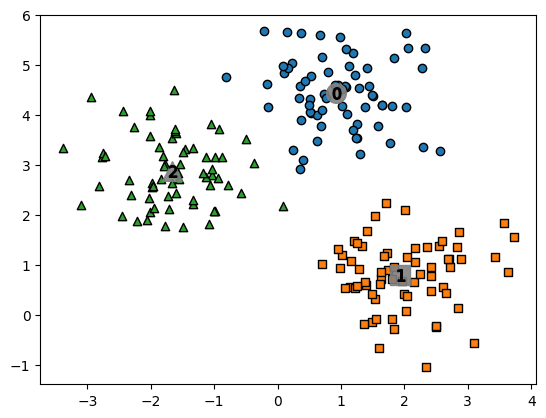

In [6]:
# 시각화
import matplotlib.pyplot as plt
%matplotlib inline

clusterDF['meanshift_label']= cluster_labels
centers = meanshift.cluster_centers_
unique_labels= np.unique(cluster_labels)
markers =['o','s','^','x','*']

for label in unique_labels:
  label_cluster = clusterDF[clusterDF['meanshift_label']==label]
  center_x_y = centers[label]

  plt.scatter(x=label_cluster['ftr1'], y= label_cluster['ftr2'], edgecolor='k', marker = markers[label])

  plt.scatter(x=center_x_y[0], y= center_x_y[1], s=200, color='gray', alpha=0.9, marker=markers[label])
  plt.scatter(x=center_x_y[0], y= center_x_y[1], s=70, color='k', edgecolor='k', marker='$%d$' %label)


plt.show()

In [7]:
print(clusterDF.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       0                  67
1       1                  67
2       2                  66
Name: count, dtype: int64


**평균이동의 장점**

데이터의 형태나 분포를 가정하지 않기 때문에 좀 더 유연한 군집화가 가능하다. 또한 이상치의 영향력도 크지 않으며 미리 군집의 개수를 정할 필요도 없다.

**단점**
알고리즘 수행 시간이 오래걸리고, h에 따른 영향이 크다.

**CV에서 많이 사용됨**

# GMM

GMM은 데이터가 여러개의 가우시안 분포를 가진 데이터 집합들이 섞여 생성된 것이라는 가정 하에 군집화를 수행하는 방식이다.

가령 천 개의 데이터 세트가 있다면 이를 구성하는 여러 개의 정규분포 곡선을 추출하고, 개별 데이터가 이중 어떤 정규분포에 속하는지 결정하는 방식이다.

**모수추정**
1) 개별 정규 분포의 평균, 분산
2) 각 데이터가 어떤 정규분포에 해당하는 지의 확률

이를 위해 EM 방법을 적용한다,

In [8]:
# 붓꽃 데이터 세트 군집화
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris=load_iris()
feature_names=['sepal_length', 'sepal_width','petal_length','petal_width']

irisDF=pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target']= iris.target

In [9]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0).fit(iris.data)
gmm_cluster_labels= gmm.predict(iris.data)

irisDF['gmm_cluster']=gmm_cluster_labels
irisDF['target']=iris.target

iris_result = irisDF.groupby(['target'])['gmm_cluster'].value_counts()
print(iris_result)

target  gmm_cluster
0       0              50
1       2              45
        1               5
2       1              50
Name: count, dtype: int64


타겟 0은 cluster 0으로, 2는 cluster 1로 매칭되었다. 타겟 1만 cluster 2로 90% , 1로 10% 매핑되었다.


In [10]:
kmeans= KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0).fit(iris.data)
kmeans_cluster_labels= kmeans.predict(iris.data)
irisDF['kmeans_cluster']=kmeans_cluster_labels
iris_result = irisDF.groupby(['target'])['kmeans_cluster'].value_counts()
print(iris_result)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


target  kmeans_cluster
0       1                 50
1       0                 48
        2                  2
2       2                 36
        0                 14
Name: count, dtype: int64


# K means와 GMM의 비교

K means는 원형의 범위에서 군집화를 수행하므로 데이터 세트가 원형의 범위를 가질수록 효율이 높아진다. 그러나 데이터가 길쭉한 타원형일 경우 효율이 떨어진다.

In [17]:
# 군집 시각화 함수

def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):

    if iscenter:
      centers= clusterobj.cluster_centers_

    unique_labels= np.unique(dataframe[label_name].values)

    markers=['o','s','^','x','*']
    isNoise = False

    for label in unique_labels:
      label_cluster = dataframe[dataframe[label_name]==label]

      if label == -1:
        cluster_legend ='Noise'
        isNoise = True

      else :
        cluster_legend= 'Cluster'+ str(label)

      plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,
                  edgecolor='k', marker= markers[label], label=cluster_legend)

      if iscenter:
        center_x_y = centers[label]
        plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                    alpha=0.9, edgecolor='k', marker= markers[label])
        plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',
                    edgecolor='k', marker='$%d$' % label)

      if isNoise:
        legend_loc='upper center'
      else:
        legend_loc='upper right'

      plt.legend(loc=legend_loc)
    plt.show()

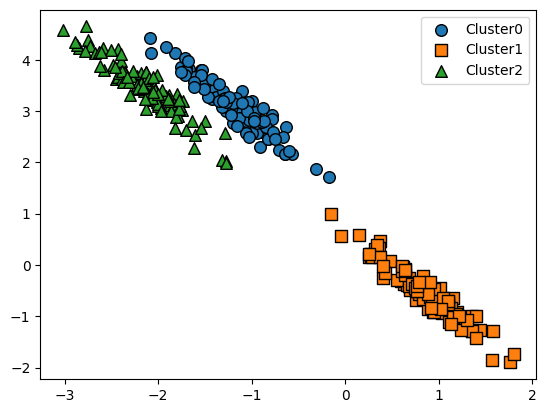

In [18]:
from sklearn.datasets import make_blobs

X,y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)

transformation =[[0.60834549, -0.63667341],[-0.40887718, 0.85253229]]

X_aniso=np.dot(X, transformation)

clusterDF = pd.DataFrame(data=X_aniso, columns=['ftr1','ftr2'])
clusterDF['target']=y

visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


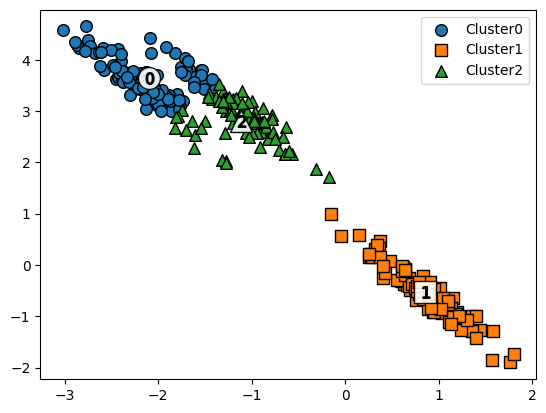

In [21]:
kmeans= KMeans(3, random_state=0)
kmeans_label =kmeans.fit_predict(X_aniso)
clusterDF['kmeans_label']= kmeans_label

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_label', iscenter=True)